In [2]:
# Install necessary packages
!pip install torch -q
!pip install torchaudio -q
!pip install transformers -q
!pip install librosa -q

In [3]:
from transformers import AutoModelWithLMHead, AutoModelForCausalLM, AutoTokenizer
from transformers import WhisperForConditionalGeneration, WhisperConfig, WhisperProcessor
import torchaudio
import nltk
from pydub import AudioSegment
import re
from datasets import load_dataset

In [4]:
import torch
import torchaudio
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer
import librosa

In [5]:
# Load pre-trained model and tokenizer
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h-lv60-self")
tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-large-960h-lv60-self")

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h-lv60-self and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/opt/conda/lib/python3.7/site-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:755: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  FutureWarning,


In [6]:
device = "cuda:0" if "cuda:0" else "cpu"

In [7]:
model = model.to(device)

In [8]:
# Load audio file
audio_file = "/kaggle/input/taylor-songs1/Taylor_Swift_-_Blank_SpaceConverteZilla.com.mp3"
audio, sr = librosa.load(audio_file, sr=16000)

In [14]:
# Set window size and hop length
window_size = int(sr*60) # 60 seconds
hop_length = int(window_size/2)

In [15]:
# Split audio signal into smaller segments
segments = []
for i in range(0, len(audio)-window_size, hop_length):
    segment = audio[i:i+window_size]
    segments.append(segment)

In [16]:
# Convert each audio segment to text
transcriptions = []
for segment in segments:
    input_values = tokenizer(segment, return_tensors="pt").input_values
    with torch.no_grad():
        input_values = input_values.to(device)
        logits = model(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = tokenizer.batch_decode(predicted_ids)[0]
    transcriptions.append(transcription)

In [17]:
# Merge text outputs to get complete lyrics
lyrics = " ".join(transcriptions)

In [18]:
lyrics = lyrics.lower()

In [ ]:
# model_name = "openai/whisper-tiny.en"
# model_config = WhisperConfig.from_pretrained(model_name)
# processor = WhisperProcessor.from_pretrained(model_name)
# asr_model = WhisperForConditionalGeneration.from_pretrained(model_name, config=model_config)

# asr_model.eval()

In [ ]:
# ds = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")
# sample = ds[0]["audio"]

In [ ]:
# input_features = processor(sample["array"], sampling_rate=sample["sampling_rate"], return_tensors="pt").input_features 
# transcript = asr_model.generate(input_features)

In [ ]:
# predicted_ids = asr_model.generate(input_features)
# transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)

In [ ]:
# print(transcription[0])

In [ ]:
# lyrics = transcription[0]

In [19]:
lyrics

"aso meyou aoani can showyou in edible i as manes aven san o a anan my go look at that ase you look tk my next ma aa tan on money e  rad ika agan n oney u  you boto lets be n ates ta atheonno pafor in my hand i can make te bat as good for a week and soa an o an odn tiadlibaga oney  yoot thets ben a ie  othen pasfor in my hand i can make the batgis good for a week and a ba and a aon es tell aiba a bb and an tai lips crystal skiesisses  annyou find ot what you want be that o for a mont ioesis yet  o no crying mao garden tary lips crystal skiesaoisses angnyou fino what you want be that o for a mont wiyet o no crying oaii getelo on you darling i'm a nightmare dressed like a day dream forevere thorni gl on you darling i'm a nightmare dressed like a daydreamand i right nae aays only one love fit torturoo say sand i right  na aways only one love if its torture don't say i didn't say i didn't want yo alwayys only ont love if it's torture don't say i didn't say i didn't wa yo didn't say i didn'

In [20]:
from transformers import AutoModelWithLMHead, AutoTokenizer, set_seed, pipeline
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

In [21]:
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelWithLMHead.from_pretrained(model_name)

/opt/conda/lib/python3.7/site-packages/transformers/models/auto/modeling_auto.py:1252: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


In [22]:
def generate_summary(lyrics):
    summarizer = pipeline("summarization", model="philschmid/bart-large-cnn-samsum")
    summary = summarizer(lyrics)
    return summary

In [23]:
# Set up GPT-2 model and tokenizer
model_name = 'gpt2'
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

In [24]:
# Set the device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
model = model.to(device)

In [26]:
summary_1 = generate_summary(lyrics)

In [27]:
print(summary_1[0]['summary_text'])

In his hand he can make the batgis good for a week and a ba and a aon es, aiba a bb and an tai lips crystal skiesisses. He's a nightmare dressed like a daydream. He'll write your name and he'll write her name.


In [28]:
def generate_prompt(summary):
    # Generate prompt text using GPT-2
    prompt = f"Create an image that represents the feeling of '{summary}'"

    # Generate the image prompt
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    output = model.generate(input_ids, do_sample=True, max_length=100, temperature=0.7)
    prompt_text = tokenizer.decode(output[0], skip_special_tokens=True)
    
    return prompt_text

In [29]:
prompt_text_1 = generate_prompt(summary_1[0]['summary_text'])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [30]:
print(prompt_text_1)

Create an image that represents the feeling of 'In his hand he can make the batgis good for a week and a ba and a aon es, aiba a bb and an tai lips crystal skiesisses. He's a nightmare dressed like a daydream. He'll write your name and he'll write her name.'

He said, 'I don't have a problem with that. You can live a good life. You can do anything you want, from a


In [31]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Tue Mar 14 21:01:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/

In [32]:
!pip install diffusers==0.11.1 -q
!pip install transformers scipy ftfy accelerate -q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [33]:
import torch
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16) 

Fetching 20 files:   0%|          | 0/20 [00:00<?, ?it/s]

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


In [34]:
pipe = pipe.to("cuda")

In [35]:
import torch
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [36]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, DPMSolverMultistepScheduler

# 1. Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# 2. Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.post_layernorm.bias', 'vision_model.encoder.layers.8.self_attn.v_proj.weight', 'vision_model.embeddings.class_embedding', 'vision_model.encoder.layers.20.self_attn.v_proj.weight', 'vision_model.encoder.layers.1.mlp.fc2.bias', 'vision_model.encoder.layers.13.self_attn.q_proj.bias', 'vision_model.encoder.layers.17.self_attn.v_proj.weight', 'vision_model.encoder.layers.18.self_attn.out_proj.bias', 'vision_model.encoder.layers.7.mlp.fc2.weight', 'vision_model.encoder.layers.0.self_attn.q_proj.weight', 'vision_model.encoder.layers.7.self_attn.k_proj.weight', 'vision_model.encoder.layers.14.layer_norm2.weight', 'vision_model.encoder.layers.2.layer_norm1.bias', 'vision_model.encoder.layers.20.self_attn.q_proj.bias', 'vision_model.encoder.layers.4.layer_norm2.bias', 'vision_model.encoder.layers.2.self_attn.v_proj.weight', 'vision_model.encoder.layers.0.mlp.fc1.wei

In [37]:
from diffusers import LMSDiscreteScheduler

scheduler = DPMSolverMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

In [38]:
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device) 

In [39]:
# prompt = ["still of darth vader in the streets of cyberpunk 2077 facing the camera holding a lightsaber, volumetric lighting, neon lights, bokeh, octane render, cinematic overlay, style by denis villeneuve"]
prompt = prompt_text_1

height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion

num_inference_steps = 50            # Number of denoising steps

guidance_scale = 7.5                # Scale for classifier-free guidance

generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise

batch_size = 1

In [40]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

In [41]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]  

In [42]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [43]:
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)

In [44]:
scheduler.set_timesteps(num_inference_steps)

In [45]:
latents = latents * scheduler.init_noise_sigma

In [46]:
from tqdm.auto import tqdm
from torch import autocast

for t in tqdm(scheduler.timesteps):
  # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/50 [00:00<?, ?it/s]

In [47]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents

with torch.no_grad():
    image = vae.decode(latents).sample

In [48]:
from PIL import Image

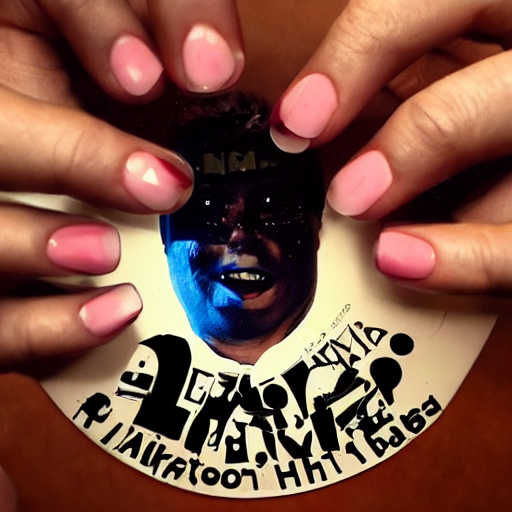

In [49]:
# DPM Solver Multistep scheduler
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]